In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.74:8787/status,
Dashboard: http://10.148.0.74:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.74:53582,Workers: 0
Dashboard: http://10.148.0.74:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [3]:
# no PEACHY data
labels=labels[:2]

# only erastar
list_wd_srce_suffix = ['es']
_stress_var = [v for v in diag._stress_var if 'es' in v]

DS={}
for l in labels:
    #OPEN DATA FILES
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
    ds_stress= xr.open_zarr(zarr_dir+'/erastar/erastar_'+l+'.zarr')# TO CHANGE ONCE GOOD FILES GENERATED
    ds_corr = xr.open_zarr(zarr_dir+'/slacorrection_'+l+'.zarr')
    ds_aviso = xr.open_zarr(zarr_dir+'/aviso_'+l+'.zarr')    
    #
    ds = xr.merge(diag.datasets_for_pdfs(ds_data, ds_aviso, ds_stress, ds_corr, sum_ = True, except_ = True, _stress_var = _stress_var,
                      list_wd_srce_suffix = list_wd_srce_suffix
                     ))
    #deltaT<1h
    ds= ds.where(ds.alti___time_difference<=1800, drop=True)#deltaT<1h
    ds= ds.where(ds.alti___distance<=1e5, drop=True)
    DS[l]=ds.persist()
    print(l)

gps_SASSA_SARAL_2018
gps_SASSA_Sentinel_2018


In [4]:
DS[labels[1]] #74124 ->66979+66339

<xarray.Dataset>
Dimensions:                                                    (obs: 66312,
                                                                box_x: 80,
                                                                box_y: 40,
                                                                id_comb: 36)
Coordinates: (12/13)
    alti___distance                                            (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    alti___time_difference                                     (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
  * box_x                                                      (box_x) float64 ...
  * box_y                                                      (box_y) float64 ...
    drifter_lat                                                (obs) float64 dask.array<chunksize=(66312,), meta=np.ndarray>
    drifter_lon                                                (obs) float64 dask.array<chunksize=(66312,), meta=np.ndarray>
    ...                                                         ...
    drifter_x                                                  (obs) float64 dask.array<chunksize=(66312,), meta=np.ndarray>
    drifter_y                                                  (obs) float64 dask.array<chunksize=(66312,), meta=np.ndarray>
    lat                                                        (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    lon                                                        (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    time                                                       (obs) datetime64[ns] dask.array<chunksize=(33035,), meta=np.ndarray>
  * id_comb                                                    (id_comb) <U44 ...
Dimensions without coordinates: obs
Data variables: (12/185)
    alti_g_grad_x                                              (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    alti_denoised_g_grad_x                                     (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    drifter_acc_x                                              (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    drifter_acc_y                                              (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    drifter_coriolis_x                                         (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    drifter_coriolis_y                                         (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    ...                                                         ...
    sum_co_adt_oceantide_dac_es_cstrio_z15_alti_x              (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    sum_co_adt_oceantide_dac_es_cstrio_z15_drifter_x           (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    sum_aviso_es_cstrio_z0_alti_y                              (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    sum_aviso_es_cstrio_z15_alti_y                             (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    sum_aviso_es_cstrio_z0_drifter_y                           (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
    sum_aviso_es_cstrio_z15_drifter_y                          (obs) float64 dask.array<chunksize=(421,), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-Sentinel-3_A__gps
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

# LON LAT bins

In [5]:
dl = 5
lon_bin, lat_bin = np.arange(-180, 180, dl), np.arange(-90,90,dl)
bins_lonlat =[lon_bin,lat_bin]

min_coloc_bin = 50

In [6]:
# nb coloc/bins
ds_repart = xr.concat([diag.coloc_repartition(DS[l], bins= bins_lonlat) for l in DS.keys()], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
ds_repart = ds_repart.where(ds_repart!=0, np.nan)

ds_repart_all = ds_repart.sum(dim='drifter_sat_year')

print(1)

# PDFs
acc_bins=np.arange(-1e-4,1e-4,1e-6)
acc_bins1=np.arange(-5e-3,5e-3,1e-5)

bins_list = {"acc": acc_bins, "lon" : lon_bin, "lat": lat_bin}
ds_pdf = xr.concat([diag.compute_pdfs(DS[key], bins_list) for key in DS], dim=pd.Index(DS.keys(), name='drifter_sat_year'))
ds_pdf['nb_coloc_bins']=ds_repart.assign_attrs({'description':'number of colocalisations per bins', 'long_name':'colocalisations/bins'})
ds_pdf.attrs = {'description':'pdf for erastar, labels[:2], with alti__time_difference<1h', 'lonlatbin':dl, 'min_coloc_bin': min_coloc_bin}

1


In [7]:
ds_pdf

<xarray.Dataset>
Dimensions:                                                        (
                                                                    acc_bin: 200,
                                                                    lon_bin: 71,
                                                                    lat_bin: 35,
                                                                    drifter_sat_year: 2,
                                                                    id_comb: 36)
Coordinates:
  * acc_bin                                                        (acc_bin) float64 ...
  * lon_bin                                                        (lon_bin) float64 ...
  * lat_bin                                                        (lat_bin) float64 ...
  * id_comb                                                        (id_comb) <U44 ...
  * drifter_sat_year                                               (drifter_sat_year) object ...
Data variables: (12/187)
    pdf_alti_g_grad_x                                              (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_alti_denoised_g_grad_x                                     (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_acc_x                                              (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_acc_y                                              (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_coriolis_x                                         (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_coriolis_y                                         (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    ...                                                             ...
    pdf_sum_aviso_es_cstrio_z0_alti_y                              (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z15_alti_y                             (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z0_drifter_y                           (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z15_drifter_y                          (drifter_sat_year, acc_bin, lon_bin, lat_bin) float64 ...
    nb_coloc                                                       (drifter_sat_year) int64 ...
    nb_coloc_bins                                                  (drifter_sat_year, lon_bin, lat_bin) float64 ...
Attributes:
    description:    pdf for erastar, labels[:2], with alti__time_difference<1h
    lonlatbin:      5
    min_coloc_bin:  50

In [8]:
zarr = os.path.join(zarr_dir, f"pdf_lonlat_bin{dl}_sentinel_saral_gps.zarr")
ds_pdf.to_zarr(zarr, mode="w")  
print(f"pdf storred in {zarr}")

pdf storred in /home1/datawork/mdemol/m2/pdf_lonlat_bin5_sentinel_saral_gps.zarr


In [9]:
ds_pdf_all = (ds_pdf.nb_coloc*ds_pdf[[v for v in ds_pdf if 'pdf' in v]]).sum('drifter_sat_year')/(ds_pdf.nb_coloc.sum('drifter_sat_year'))#normalized
ds_pdf_all['nb_coloc_bins'] = ds_pdf.nb_coloc_bins.sum('drifter_sat_year')
ds_pdf_all['id_comb'] = ds_pdf['id_comb']
ds_pdf_all = ds_pdf_all.where(ds_pdf_all.nb_coloc_bins>=min_coloc_bin)
for v in ds_pdf_all : 
    ds_pdf_all[v].attrs = ds_pdf[v].attrs
ds_pdf_all

<xarray.Dataset>
Dimensions:                                                        (
                                                                    acc_bin: 200,
                                                                    lon_bin: 71,
                                                                    lat_bin: 35,
                                                                    id_comb: 36)
Coordinates:
  * acc_bin                                                        (acc_bin) float64 ...
  * lon_bin                                                        (lon_bin) float64 ...
  * lat_bin                                                        (lat_bin) float64 ...
  * id_comb                                                        (id_comb) <U44 ...
Data variables: (12/186)
    pdf_alti_g_grad_x                                              (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_alti_denoised_g_grad_x                                     (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_acc_x                                              (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_acc_y                                              (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_coriolis_x                                         (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_drifter_coriolis_y                                         (acc_bin, lon_bin, lat_bin) float64 ...
    ...                                                             ...
    pdf_sum_co_adt_oceantide_dac_es_cstrio_z15_drifter_x           (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z0_alti_y                              (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z15_alti_y                             (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z0_drifter_y                           (acc_bin, lon_bin, lat_bin) float64 ...
    pdf_sum_aviso_es_cstrio_z15_drifter_y                          (acc_bin, lon_bin, lat_bin) float64 ...
    nb_coloc_bins                                                  (lon_bin, lat_bin) float64 ...

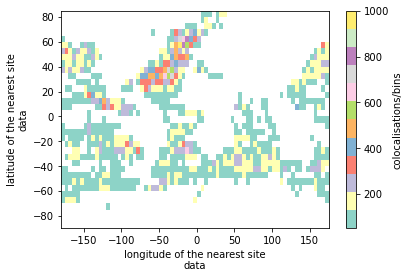

In [10]:
ds_pdf_all.nb_coloc_bins.plot(x='lon_bin', y='lat_bin', cmap='Set3')

In [11]:
ds_std_all = diag.ds_mean_var_std(ds_pdf_all,'acc_bin', mean=True, var=True, rms=True)

In [12]:
ds_std_all

<xarray.Dataset>
Dimensions:                                                         (
                                                                     lon_bin: 71,
                                                                     lat_bin: 35,
                                                                     id_comb: 36)
Coordinates:
  * lon_bin                                                         (lon_bin) float64 ...
  * lat_bin                                                         (lat_bin) float64 ...
  * id_comb                                                         (id_comb) <U44 ...
Data variables: (12/926)
    mean_alti_g_grad_x                                              (lon_bin, lat_bin) float64 ...
    var_alti_g_grad_x                                               (lon_bin, lat_bin) float64 ...
    std_alti_g_grad_x                                               (lon_bin, lat_bin) float64 ...
    rms_alti_g_grad_x                                               (lon_bin, lat_bin) float64 ...
    ms_alti_g_grad_x                                                (lon_bin, lat_bin) float64 ...
    mean_alti_denoised_g_grad_x                                     (lon_bin, lat_bin) float64 ...
    ...                                                              ...
    mean_sum_aviso_es_cstrio_z15_drifter_y                          (lon_bin, lat_bin) float64 ...
    var_sum_aviso_es_cstrio_z15_drifter_y                           (lon_bin, lat_bin) float64 ...
    std_sum_aviso_es_cstrio_z15_drifter_y                           (lon_bin, lat_bin) float64 ...
    rms_sum_aviso_es_cstrio_z15_drifter_y                           (lon_bin, lat_bin) float64 ...
    ms_sum_aviso_es_cstrio_z15_drifter_y                            (lon_bin, lat_bin) float64 ...
    nb_coloc_bins                                                   (lon_bin, lat_bin) float64 ...

In [13]:
zarr = os.path.join(zarr_dir, f"stat_lonlat_bin{dl}_lim{min_coloc_bin}_sentinel_saral_gps.zarr")
ds_std_all.to_zarr(zarr, mode="w")  
print(f"diag storred in {zarr}")

diag storred in /home1/datawork/mdemol/m2/stat_lonlat_bin5_lim50_sentinel_saral_gps.zarr


In [14]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
